# Addressing Class Imbalance 

At this point, you have learnt a fair bit about classification model. In our demo dataset, our target variable has two classes. Is there something that we have failed to address about our target variable? As a professional trainer, we cannot omit the one of most important steps of the data analytics life cycle - Data Exploration and Cleaning!
What does your target variable's distribution look like? Are they balance? Is one class represented to a lesser degree? 

Today, we are going to introduce a few methods to address class imbalance. Then, we are going to re-train our classification models that we have already learnt, and see if there would be a different result! 

## Outline <a name="top"></a>
1. [Class Imbalance](#imbalance)
2. [House Price Data Preparation](#cleaning)
    1. [Stratification](#strat)
    2. [AUC-ROC curve](#auc)
    3. [Cohen's Kappa](#ck)
3. [Resampling methods](#resampling)
    1. [OverSampling](#oversampling)
    2. [UnderSampling](#undersampling)
    3. [SMOTE](#smote)
6. [Activity](#activity)

## Class Imbalance 

Class Imbalance refers to when observation in one class is higher than in other classes. Training procedures of standard classification algorithms are biased towards the majority class, as they strive to maximise classification accuracy or minimise error. If the dataframe has imbalanced classes, we get a pretty high accuracy just by predicting the majority class, but we fail to capture the minority class, which is most often the point of creating the model in the first place. 
It is common for classification problems to be imbalanced, with some of the most significant coming from application areas such as biomedicine, finance, information technology, industrial production, and security management. In most cases, it is crucial to recognise the minority class instance. 

In [2]:
!pip install imblearn


In [3]:
### loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, roc_curve, roc_auc_score

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## Data Preparation <a name="cleaning"></a>

We will be using the london house price data for this class imbalance demonstration again. 

The cleaning process would be exactly the same as last week. But we want to explore our data a bit more by looking into the distribution of our target variable. 


In [4]:
## Read in comma separated file 

df = pd.read_csv('./london_house_price_data.csv',index_col = [0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   link                  1468 non-null   object 
 1   saleprice             1379 non-null   float64
 2   address               1379 non-null   object 
 3   description           1468 non-null   object 
 4   added_date            1371 non-null   object 
 5   agent                 1468 non-null   object 
 6   property_type         1468 non-null   object 
 7   bedrooms              1468 non-null   int64  
 8   bathrooms             1468 non-null   int64  
 9   distance_to_station   1379 non-null   object 
 10  tenure                1254 non-null   object 
 11  leasehold_years_left  86 non-null     float64
 12  postcode              1021 non-null   object 
 13  borough               1021 non-null   object 
 14  crime_rate            1021 non-null   float64
 15  total_area           

In [5]:
def clean(df):
    ## Removing columns 
    byebye_col = ['link','address','description','added_date','sold_date','agent','postcode', 'borough']
    df = df.drop(columns = byebye_col)
    
    # Remove word "miles" in column "distance_to_station"
    df['distance_to_station'] = df['distance_to_station'].str.replace(' miles', '').astype('float')
    
    # Combining the property type of bungalow into house 
    df['property_type'] = df['property_type'].replace(['Detached Bungalow', 'Retirement Property', 'Semi-Detached Bungalow'], 'House')
    
    # Remove column leasehold_years_left
    df = df.drop('leasehold_years_left', axis = 1)
    
    # Dropping rows with target variable missing
    df.dropna(subset=['sold_under_90days'], inplace=True)
    df['sold_under_90days'] = df['sold_under_90days'].astype(int)
    
    return df

In [6]:
df = clean(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1379 entries, 0 to 1467
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   saleprice            1379 non-null   float64
 1   property_type        1379 non-null   object 
 2   bedrooms             1379 non-null   int64  
 3   bathrooms            1379 non-null   int64  
 4   distance_to_station  1379 non-null   float64
 5   tenure               1188 non-null   object 
 6   crime_rate           1021 non-null   float64
 7   total_area           1379 non-null   float64
 8   year_built           1379 non-null   int64  
 9   property_condition   1379 non-null   float64
 10  amenities_rating     1379 non-null   float64
 11  garden               1379 non-null   bool   
 12  balcony              1379 non-null   bool   
 13  fuel_type            1379 non-null   object 
 14  sold_under_90days    1379 non-null   int64  
dtypes: bool(2), float64(6), int64(4), obje

In [7]:
## Impute missing values using Simple Imputation method - let's impute our numerical values with 'mean' value and the categorical with 'most_frequent'
### Since we need to impute on both X_train and X_test separately, let's use a function to avoid repeating ourselves!!

def impute_missing_values(df):
    # Separate numerical and categorical features
    num_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    cat_features = df.select_dtypes(include=['object']).columns.tolist()

    # Create separate SimpleImputer instances for numerical and categorical features
    num_imputer = SimpleImputer(strategy='mean')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    # Impute missing values in numerical features
    df_num = df[num_features]
    df_num_imputed = num_imputer.fit_transform(df_num)

    # Convert the imputed numerical features back to a DataFrame
    df_num_imputed_df = pd.DataFrame(df_num_imputed, columns=num_features)

    # Impute missing values in categorical features
    df_cat = df[cat_features]
    df_cat_imputed = cat_imputer.fit_transform(df_cat)

    # Convert the imputed categorical features back to a DataFrame
    df_cat_imputed_df = pd.DataFrame(df_cat_imputed, columns=cat_features)

    # Combine the numerical and categorical DataFrames back into one DataFrame
    df_imputed = pd.concat([df_num_imputed_df, df_cat_imputed_df], axis=1)
    
    return df_imputed

### Assess the Degree of Imbalance 

In [8]:
# Calculate the minority class percentage 
min(df.sold_under_90days.value_counts()/len(df))
#It's a mild to moderate imbalance

0.26468455402465557

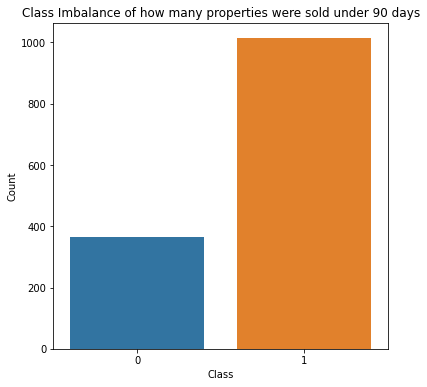

In [9]:
# You can also plot a graph to view 
plt.figure(figsize=(6,6))
sns.barplot(x=df['sold_under_90days'].value_counts().index, y=df['sold_under_90days'].value_counts().values)
plt.title('Class Imbalance of how many properties were sold under 90 days')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Stratification <a name="strat"></a>

Stratification means we are dividing our dataset into subsets (often during train-test-split/ cross-validation) in a way that each subset *maintains the same class distribution as the original dataset*. In other words, the proportion of each class in each subset is preserved, which can help prevent the majority class from dominating the learning process.

**Note : this method does NOT change the data itself but rather to ensure that the train and test sets follow the same distribution as our original dataset.**

Rather than using the default train_test_split provided by scikit-learn, we should try to make sure our splits accurately represent the distribution of our target variable. A very simple way to do this is to use the *stratify parameter* when calling the train_test_split function.

In [10]:
# extract the target
X = df.drop(columns = ['sold_under_90days'])
y = df['sold_under_90days']

# Train Test Split with stratification on target variable
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=456, stratify = y)

In [11]:
#It's important to reset the indices as this can be a bit messy after splitting - especially if we intend to reuinify those datasets
X_train.reset_index(drop=True, inplace = True)
y_train.reset_index(drop=True, inplace = True)

In [12]:
# Checking the proportion of our target variable in both train and test set
y_train.value_counts()/len(y_train)

1    0.735267
0    0.264733
Name: sold_under_90days, dtype: float64

In [13]:
y_test.value_counts()/len(y_test)

1    0.735507
0    0.264493
Name: sold_under_90days, dtype: float64

In [14]:
# Imputataion
X_train_imputed = impute_missing_values(X_train)
X_test_imputed = impute_missing_values(X_test)

## One-hot encoding on categorical columsn before training the model 
X_train_encoded = pd.get_dummies(X_train_imputed, columns=['property_type','tenure','fuel_type'])
X_test_encoded = pd.get_dummies(X_test_imputed, columns=['property_type', 'tenure','fuel_type'])

In [15]:
dt_strat_model = tree.DecisionTreeClassifier(max_depth=4, random_state=423)
dt_strat_model.fit(X_train_encoded, y_train)
train_predictions = dt_strat_model.predict(X_train_encoded)
y_pred = dt_strat_model.predict(X_test_encoded)

from sklearn.metrics import accuracy_score
print("Training Accuracy: ",accuracy_score(train_predictions, y_train))
print("Testing Accuracy: ",accuracy_score(y_pred, y_test))

Training Accuracy:  0.8232094288304623
Testing Accuracy:  0.8007246376811594


In [16]:
from sklearn.metrics import precision_score, recall_score

precision_dt_strat = precision_score(y_test, y_pred)
recall_dt_strat = recall_score(y_test, y_pred)
print(precision_dt_strat)
print(recall_dt_strat)

0.8457943925233645
0.8916256157635468


It seems that both precision and recall has reduced after stratification (trust me on this :D), can you think of WHY it might happen?

<details>
<summary>Click to see some potential reasons </summary>

If the original dataset has a class imbalance, the model might have been biased towards the majority class, leading to a high precision for the majority class (due to correct predictions of majority class samples), but a poor recall for the minority class (due to missed predictions of minority class samples). After stratification, the training dataset becomes more balanced, allowing the model to learn from both classes more effectively. This could then cause the precision of the majority class to decrease as the model becomes more cautious in making positive predictions for the majority class. 

</details> 



### AUC-ROC curve <a name="auc"></a>

A **receiver operating characteristic curve (ROC curve)** is another useful tool for evaluating classification models. The ROC curve is a graphical representation of a binary classifier's performance as the decision threshold is varied. By default, the threshold for predicting a label is 0.5, but it doesn't have to be. It is created by plotting the True Positive Rate (Sensitivity/Recall) on the y-axis against the False Positive Rate (1 - Specificity) on the x-axis at various threshold values. Each point on the curve represents the trade-off between the true positive rate and the false positive rate at a particular threshold. A ROC curve will for every threshold between 0 and 1 compare the true positive rate and true negative rate. 

You have already learnt the true positive rate- it is the recall. The false positive rate is the recall for the negative label.

\begin{equation*}
FPR = {FP}/ {FP+TN}
\end{equation*}

It illustrates how well the model separates the positive and negative samples as the decision threshold changes. A good classifier will have an ROC curve that rises steeply towards the top-left corner, indicating high true positive rates and low false positive rates for various threshold values.
When you plot these metrics against each other you get a curve, the further this curve stretches into the top right of the visualisation, the better your model is at prediction. If it forms a diagonal line it is not good for prediction at all.

The **AUC** is a single scalar value that summarizes the overall performance of the classifier across all possible decision thresholds. It represents the area under the ROC curve and ranges between 0 and 1.

- AUC = 0.5: If the AUC is 0.5, it means the model's performance is equivalent to random chance. This is because the ROC curve coincides with the diagonal line (the line of no-discrimination), which represents a random classifier.

- AUC > 0.5: An AUC greater than 0.5 indicates better-than-random performance. The closer the AUC is to 1, the better the classifier's ability to distinguish between positive and negative samples.

- AUC = 1: A perfect classifier has an AUC of 1, which means it achieves perfect separation between positive and negative samples for all decision thresholds.

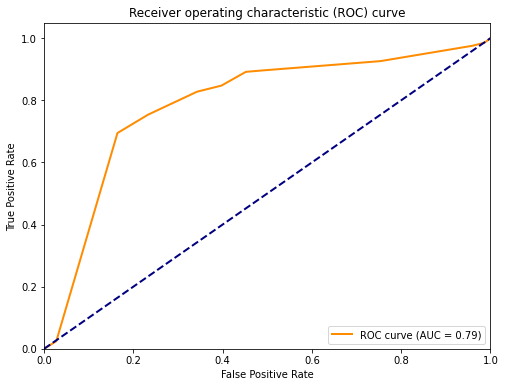

AUC score: 0.7891220730143734


In [17]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = dt_strat_model.predict_proba(X_test_encoded)[:, 1]  # Probability estimates of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print('AUC score:', roc_auc)

### Cohen's Kappa <a name="ck"></a>

Cohen's Kappa takes into account the level of agreement between raters beyond what would be expected by chance alone. It measures the degree of agreement while considering the possibility of random agreement. The value of Kappa can range from -1 to 1:

- Kappa = -1: Perfect disagreement beyond what would be expected by chance.
- Kappa < 0: Agreement is less than what would be expected by chance.
- Kappa = 0: Agreement is equal to what would be expected by chance.
- Kappa > 0: Agreement is greater than what would be expected by chance.
- Kappa = 1: Perfect agreement beyond what would be expected by chance.

A Kappa value of 0 means that the observed agreement is equal to the agreement expected by chance, indicating no better than random agreement. A Kappa value greater than 0 indicates that the observed agreement is better than random, while a negative Kappa value suggests less agreement than expected by chance.

Cohen's Kappa is often used when evaluating the performance of classification models, especially in cases where the class distribution is imbalanced. It helps account for the effect of chance agreement and provides a more reliable measure of agreement or performance between different raters or classifiers. A higher Kappa value indicates better agreement or classification performance.

In [18]:
# Calculate Cohen's Kappa score
kappa = cohen_kappa_score(y_test, y_pred)

print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.4618547929665343


## Resampling methods <a name="resampling"></a>

### Oversampling - duplicating <a name="oversampling"></a>
Oversampling is when we duplicate samples from the **minority** class. We want to balance the data set by increasing the size of the minority class to match the size of the majority class – this way, our classes are equal.

<img src="duplicating.png" width="450" align="center">

**Pros**
 - Does not decrease size of dataset 
 - Does not lose any information 
 - Can handle complex models 
 
**Cons**
- Can increase chance of overfitting: as it creates additional samples by duplicating minority class samples, they are identical to existing samples, providing redundatn information to the model. When a model sees the same samples multiple times during training, it can become overconfident in its ability to classify them correctly. Something SMOTE can overcome...
- May increase training time (depends on your dataset size...)

### Unsampling - deleting <a name="undersampling"></a>

Undersampling is when we delete samples from the **majority** class. We want to balance the data set by decreasing the size of the majority class to match the size of the minority class – this way, our classes are equal.

<img src="deleting.png" width="450" align="center">

Both oversampling and undersampling involve introducing a bias to select more samples from one class than from another, to compensate for an imbalance that is either already present in the data, or likely to develop if a purely random sample were taken.

**Pros**
- Does not introduce redundant information to dataset
- Reduces training time

**Cons** 
- Reduces size of dataset
- Loss of information 

### SMOTE - Synthetic Minority Oversampling Technique <a name="smote"></a>

SMOTE is a one of the most common oversampling technique. The algorithm generates synthetic samples for the minority class by creating new synthetic data points.

This is how a round of SMOTE works:

- Step 1: Choose any random datapoint (i.e., a row) in the Minority Class as a starting point.
- Step 2: Find the 5 nearest neighbours of that datapoint, considering all other variables.
- Step 3: Pick a random one of those five nearest neighbours.
- Step 4: Compute a synthetic datapoint the average of the neighbour and the datapoint in terms of each variable. This might be a bit whacky for any variable that is not numeric - but that is why SMOTE is generally only recommended to be used on numeric variables (although it does "work" with non-numeric variables too... just not as well).
- Step 5: Add that synthetic datapoint to the entire dataset, so it can be drawn as either a starting point or a neighbour in the next round.

This process will be repeated for as many rounds, until the desired ratio of minority and majority cases is reached.


<img src="deleting.png" width="450" align="center">

There is a *imbalanced-learn* framework which was initiated in 2014 with the main focus being on **SMOTE (another technique for imbalanced data) implementation**. Here is a link to [Imbalanced-Learn](https://imbalanced-learn.org/stable/over_sampling.html) for guides on installation and the full documentation. For those who can pip install new library please do so! 

**However, your dearest instructor Lukas has nerded out his own "ReSampler" for those who cannot pip install. It allegedly works (just kidding, it's verified and works with a tiny tiny bit of caveats).** The function includes oversampling, undersampling and SMOTE - all in one. Happy days!

In [19]:
# Optional Install
#!pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [20]:
#Here is the pip free version: Our own ReSampler

def ReSampler(X,y,Target,Ratio,Mode,Seed):
    
    #Unite X and y for the purpose of resampling
    X[Target] = y 
    df = X
    
    if (Mode == 0) or (Mode == "Over"):
        #Get the Minority Class
        MinorityClass=df[Target].value_counts().loc[df[Target].value_counts()==min(df[Target].value_counts())].index[0]

        #Get a df of only Minority Cases - for resampling
        Minoritydf=df[df[Target]==MinorityClass]

        #Find out how many samples we need in total
        TargetTotal=round(max(df[Target].value_counts())/(1-Ratio))

        #Find out how many of our sample need to be of the minority class, so the target ratio is reached
        SamplesNeeded=TargetTotal-len(df)

        #Initialise Resampled Df
        ResampledDf=pd.DataFrame(np.empty((0,len(Minoritydf.columns))))
        ResampledDf.columns=Minoritydf.columns

        #Draw with replacement from the Minority Dataframe to get as many Samples as needed
        ResampledDf=ResampledDf.append(Minoritydf.sample(int(SamplesNeeded), replace = True, axis = 0,random_state=Seed))

        NewDf=df.append(ResampledDf)
    elif (Mode == 1) or (Mode == "Under"):
        #Get the Majority Class and Minority Class
        MajorityClass=df[Target].value_counts().loc[df[Target].value_counts()==max(df[Target].value_counts())].index[0]
        MinorityClass=df[Target].value_counts().loc[df[Target].value_counts()!=max(df[Target].value_counts())].index[0]

        #Get a df of only Minority Cases - for the output
        Minoritydf=df[df[Target]==MinorityClass]

        #Get a df of only Majority Classes - for resampling
        Majoritydf=df[df[Target]==MajorityClass]
        
        #Find out how many samples we need in total
        TargetTotal=round(min(df[Target].value_counts())/(1-Ratio))
        
        #Find out how many of our sample need to be of the majority class, so the target ratio is reached
        SamplesNeeded=TargetTotal-len(df)

        #get a list of random numbers the length of Majoritydf
        nums=list(range(len(Majoritydf)))

        #randomly reorder these numbers and draw an amount from them equal to the length of the Minoritydf
        rand.Random(Seed).shuffle(nums)
        nums=nums[0:SamplesNeeded]

        #Now use that shorter list of numbers to slice Majoritydf - so you you only select a random subset of that df that has the
        #length of Minoritydf
        Majoritydf=Majoritydf.iloc[nums,:]

        #Recombine the two df
        NewDf=Minoritydf.append(Majoritydf)
    elif (Mode == 2) or (Mode == "SMOTE"):
        #Get the Minority Class
        MajorityClass=df[Target].value_counts().loc[df[Target].value_counts()==max(df[Target].value_counts())].index[0]
        MinorityClass=df[Target].value_counts().loc[df[Target].value_counts()==min(df[Target].value_counts())].index[0]
        
        #Get a Dataframe of the MinorityClass
        Minoritydf=df[df[Target]==MinorityClass]
        
        #Get a df of only Majority Classes - for resampling
        Majoritydf=df[df[Target]==MajorityClass]
        
        #Standardise that dataframe (writign our own StandardScaler here is more efficient, because it saves us converting for DataFrame to array and back)
        StandardMinoritydf=Minoritydf.copy()
        for i in range(len(StandardMinoritydf.columns)):
            if Minoritydf.iloc[:,i].astype("float").std()==0:
                StandardMinoritydf.iloc[:,i]=(Minoritydf.iloc[:,i].astype("float")-Minoritydf.iloc[:,i].astype("float").mean())
            else:
                StandardMinoritydf.iloc[:,i]=(Minoritydf.iloc[:,i].astype("float")-Minoritydf.iloc[:,i].astype("float").mean())/Minoritydf.iloc[:,i].astype("float").std()
        
        #Initiate Nearest Neighbour Algorythm - we do 5 neighbours, as suggested in the original SMOTE paper
        Neigh=NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
        
        #Preallocating an empty dataframe with the same columns as our input
        ResampledDf=pd.DataFrame(np.empty((0,len(Minoritydf.columns))))
        ResampledDf.columns=Minoritydf.columns
        
        #Preallocating a counter for the loop
        k=1
        
        #Setting a seed
        np.random.seed(Seed)
        
        #The Main SMOTE Loop - go until the Minority data is [Ratio] percent of all data
        while (len(StandardMinoritydf))/(len(StandardMinoritydf)+len(Majoritydf)) < Ratio:
            
            #get a random number for picking a random row of data later
            i=rand.randint(0,len(StandardMinoritydf)-1)
            
            #get a random number for picking a random one of the datapoint's 5 nearest neighbours later
            j=rand.randint(0,4)
            
            #Find the 5 nearest neighbours of all current datapoints
            Neigh.fit(StandardMinoritydf)
            _, indices = Neigh.kneighbors()
            
            #Create a new datapoint that lies exactly between a randomly chosen original datapoint, and one of its nearest neighbours (randomly chosen)
            ResampledDf=pd.DataFrame((StandardMinoritydf.iloc[i,:].astype("float")+StandardMinoritydf.iloc[indices[i][j]].astype("float"))/2).transpose()
            
            #Give that new datapoint an index that counts up from the highest index number in the original dataset
            ResampledDf.index=range(df.index.max()+k,df.index.max()+k+1)
            
            #Add the new datapoint to the standardised dataframe containing all data from the minority class
            StandardMinoritydf=StandardMinoritydf.append(ResampledDf)
            
            #Increase the loop counter
            k+=1

        #For my sanity, make a copy of the now SMOTEed, but still standardised dataframe
        NewDf=StandardMinoritydf.copy()
        
        #Reverse the Standardisation process by multiplying all data by the original standard deviations of their columns, and adding their columns original means
        for i in range(len(NewDf.columns)):
            if Minoritydf.iloc[:,i].astype("float").std()==0:
                NewDf.iloc[:,i]=(StandardMinoritydf.iloc[:,i].astype("float")+Minoritydf.iloc[:,i].astype("float").mean())
            else:
                NewDf.iloc[:,i]=(StandardMinoritydf.iloc[:,i].astype("float")*Minoritydf.iloc[:,i].astype("float").std())+Minoritydf.iloc[:,i].astype("float").mean()
        
        #Unite the (SMOTEed) Minority data with the Majority data - ready to eject!
        NewDf=Majoritydf.append(NewDf)
    
    #Split the output into X and y again
    NewX = NewDf.drop(columns = [Target])
    Newy = NewDf[Target]
    
    return NewX, Newy

In [21]:
# While we are on the function train, let's have another function that allows you to print the performance metric for each class balancing method 

def get_results(truth, prediction, df, idx):

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)
    kappa = cohen_kappa_score(y_test, y_pred)

    df.loc[idx,:] = [acc, f1, precision, recall, auc, kappa]

    return df

### Using Decision Tree to try all our resampling methods! 

In [22]:
## Set up results df

results = pd.DataFrame(index = ['No resampling', 'Oversampling', 'Undersampling','SMOTE'], 
                       columns = ['accuracy', 'f1', 'precision', 'recall','auc','kappa']) #F1 is the harmonic mean of precision and recall.


In [23]:
## Build an initial model to see how it fares despite the imbalance. Let's take something simple like a decision tree

#Model training
dt_model = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=33, min_samples_leaf = 18, max_leaf_nodes = 9)
dt_model.fit(X_train_encoded, y_train)

train_predictions = dt_model.predict(X_train_encoded)
y_pred = dt_model.predict(X_test_encoded)
y_probs = dt_model.predict_proba(X_test_encoded)[:, 1]  # Probability estimates of the positive class

# Use our function to get results 
results = get_results(y_test, y_pred, results, 'No resampling')
results

,accuracy,f1,precision,recall,auc,kappa
No resampling,0.793478,0.863962,0.837963,0.891626,0.808084,0.437097
Oversampling,NaN,NaN,NaN,NaN,NaN,NaN
Undersampling,NaN,NaN,NaN,NaN,NaN,NaN
SMOTE,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Oversample with imblearn
#ros = RandomOverSampler(random_state=123)
#X_train_OverSampled, y_train_OverSampled = ros.fit_resample(X_train_encoded, y_train)  

# Oversample with Lukas's function
X_train_OverSampled, y_train_OverSampled = ReSampler(X_train_encoded, y_train,"sold_under_90days",0.5,"Over",123)

In [25]:
#let's check our classes
y_train_OverSampled.value_counts()

1.0    811
0.0    811
Name: sold_under_90days, dtype: int64

In [26]:
#Run this if you have used imblearn
#X_train_OverSampled=X_train_OverSampled.drop(columns=["sold_under_90days"])

In [27]:
# Oversampled Model training
dt_model_over = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=33, min_samples_leaf = 18, max_leaf_nodes = 9)
dt_model_over.fit(X_train_OverSampled, y_train_OverSampled)

train_predictions = dt_model_over.predict(X_train_OverSampled)
y_pred = dt_model_over.predict(X_test_encoded)
y_probs = dt_model_over.predict_proba(X_test_encoded)[:, 1]  # Probability estimates of the positive class

# Use our function to get results 
results = get_results(y_test, y_pred, results, 'Oversampling')
results

,accuracy,f1,precision,recall,auc,kappa
No resampling,0.793478,0.863962,0.837963,0.891626,0.808084,0.437097
Oversampling,0.746377,0.81383,0.884393,0.753695,0.796984,0.423937
Undersampling,NaN,NaN,NaN,NaN,NaN,NaN
SMOTE,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Undersample with imblearn
#rus = RandomUnderSampler(random_state=123)
#X_train_UnderSampled, y_train_UnderSampled = rus.fit_resample(X_train_encoded, y_train)  

# Oversample with Lukas's function
X_train_UnderSampled, y_train_UnderSampled = ReSampler(X_train_encoded, y_train,"sold_under_90days",0.5,"Under",125)

In [29]:
#let's check our classes
y_train_UnderSampled.value_counts()

0    292
1    292
Name: sold_under_90days, dtype: int64

In [30]:
#Run this if you have used imblearn
#X_train_UnderSampled=X_train_UnderSampled.drop(columns=["sold_under_90days"])

In [31]:
# Undersampled Model training
dt_model_under = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=33, min_samples_leaf = 18, max_leaf_nodes = 9)
dt_model_under.fit(X_train_UnderSampled, y_train_UnderSampled)

train_predictions = dt_model_under.predict(X_train_UnderSampled)
y_pred = dt_model_under.predict(X_test_encoded)
y_probs = dt_model_under.predict_proba(X_test_encoded)[:, 1]  # Probability estimates of the positive class

# Use our function to get results 
results = get_results(y_test, y_pred, results, 'Undersampling')
results

,accuracy,f1,precision,recall,auc,kappa
No resampling,0.793478,0.863962,0.837963,0.891626,0.808084,0.437097
Oversampling,0.746377,0.81383,0.884393,0.753695,0.796984,0.423937
Undersampling,0.753623,0.814208,0.91411,0.73399,0.817734,0.461278
SMOTE,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# SMOTE IT 
#smote = SMOTE(random_state=5)
#X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_encoded, y_train)  

# Oversample with Lukas's function
X_train_SMOTE, y_train_SMOTE = ReSampler(X_train_encoded, y_train,"sold_under_90days",0.5,"SMOTE",123)

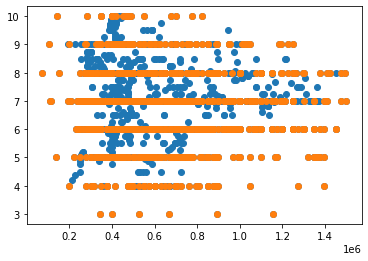

In [33]:
#Lets have a look at what it made
plt.scatter(X_train_SMOTE.iloc[:,0], X_train_SMOTE.iloc[:,7]);
plt.scatter(X_train_encoded.iloc[:,0], X_train_encoded.iloc[:,7]);

In [34]:
#Run this if you have used imblearn
#X_train_SMOTE=X_train_SMOTE.drop(columns=["sold_under_90days"])

In [35]:
# SMOTE-ed Model training
dt_model_smote = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=33, min_samples_leaf = 17, max_leaf_nodes = 9)
dt_model_smote.fit(X_train_SMOTE, y_train_SMOTE)

train_predictions = dt_model_smote.predict(X_train_SMOTE)
y_pred = dt_model_smote.predict(X_test_encoded)
y_probs = dt_model_smote.predict_proba(X_test_encoded)[:, 1]  # Probability estimates of the positive class

# Use our function to get results 
results = get_results(y_test, y_pred, results, 'SMOTE')
results

,accuracy,f1,precision,recall,auc,kappa
No resampling,0.793478,0.863962,0.837963,0.891626,0.808084,0.437097
Oversampling,0.746377,0.81383,0.884393,0.753695,0.796984,0.423937
Undersampling,0.753623,0.814208,0.91411,0.73399,0.817734,0.461278
SMOTE,0.789855,0.858537,0.850242,0.866995,0.794082,0.450237


In [36]:
accuracy_score(y_test,y_pred)

0.7898550724637681

## Activity - your turn! <a name="activity"></a>

Now it's your turn to build an Ensemble method model using a Telecom Churn dataset. 

1. [Revisit Cleaning Data](#cleaning)
2. [Revisit Data cleaning](#cleaning)
3. [Revisit Resampling methods](#resampling)

Your task is to explore this synthetic telecom churn dataset to predict behaviour of customers related to churn. It is a simple dataset that allows you to explore the newly learnt ML skills. We have demonstrated using decision tree here, have a good using Random forest/ Gradient Boost and see do you have different results! 

### Churn dataset description 
The dataset contains information about telecommunications customer churn behaviour. It is a fictional telco company that provided mobile phone and internet services and the data is synthetic.   
It contains approximately 4000 records, each representing a customer, and contains a total of 8 variables/ features. These variables cover a variety of aspects related to the customer behaviour, demographic and contract types.

For this task, can you preduct whether customers at a fictional telecom company will exit their subscription, churn or not?